# The Decorator Paradigm for Responsive Plots

[![DOI](https://zenodo.org/badge/214871831.svg)](https://zenodo.org/badge/latestdoi/214871831)

In [1]:
r"""markdown
    TITLE   : The Decorator Paradigm for Responsive Plots
    AUTHOR  : Nathaniel Starkman
    PROJECT : 2019-10-22 dotAstronomy Plotting Workshop
""";

__author__ = 'Nathaniel Starkman'
__version__ = "Oct 22, 2019"

<span style='font-size:30px;font-weight:650'>
    About
</span>

information about this notebook  
see commented out lines (below)

<br><br>

- - - 
- - - 

<br>

# Prepare

## Imports

In [2]:
from astroPHD import ipython
ipython.run_imports(base=True, astropy=True, matplotlib=True)

## General
import functools

## Custom

## Project-Specific

set autoreload to 1
base_imports:
    Base: os, sys, time, pdb, warnings,
          numpy -> np, scipy,
          tqdm -> TQDM, .tqdm, .tqdm_notebook ->. tqdmn
    Logging: .LogFile
    Misc: ObjDict
    IPython: display, Latex, Markdown, set_trace,
             printmd, printMD, printltx, printLaTeX,
             set_autoreload, aimport,
             run_imports, import_from_file,
             add_raw_code_toggle

Imported from Astropy:
    astropy, .units->u, .coordinates->coords, .SkyCoord, .Table, .QTable

Imported from Matplotlib:
    pyplot->plt
    matplotlib->mpl, .colors, .cm
    configure_matplotlib



## Functions

In [3]:
class DecoratorClassBase():
    """
    """
    
    @staticmethod
    def _doc_func(docstring):
        return docstring

    def __new__(cls, func=None, **kwargs):
        """
        this is a quick and dirty method for class-based decorator creation
        it is generically better to do this with a classmethod like
        @classmethod
        as_decorator(cls, func=None, ...):
            all the same code as here
        """
        # make instance
        self = super().__new__(cls)
        
        # wrapper control:
        if func is not None:  # this will return a wrapped function
            # pass all arguments and kwargs to init
            # since __init__ is will not be called
            self.__init__(func, **kwargs)
            return self(func)
        else:  # this will return a function wrapper
            # for when using as a @decorator
            # __init__ will be automatically called after this
            return self
    # /def

    def __init__(self, func=None, **kwargs):
        """
        these are stored to be used inside of __call__
        they are not normally passed to the wrapped_function
        """

        # store all values passed to __init__
        for k, v in kwargs.items():
            setattr(self, k, v)
    # /def

    def edit_docstring(self, wrapper):
        """blank call
        """

        # docstring
        if wrapper.__doc__ is not None:
            wrapper.__doc__ = self._doc_func(wrapper.__doc__)

        # storing extra info
        wrapper._doc_func = self._doc_func
        
        return wrapper
    # /def
# /class

## Data

In [4]:
x = np.linspace(0, 2*np.pi, num=100) * u.s

In [5]:
y = np.cos(x * u.rad / u.s) * u.m

<br><br>

- - - 
- - - 

<br>

# Scripting Plots

Text(0.5, 0, 'time [$\\mathrm{s}$]')

Text(0, 0.5, 'distance [$\\mathrm{m}$]')

Text(0.5, 1.0, 'This is a Title')

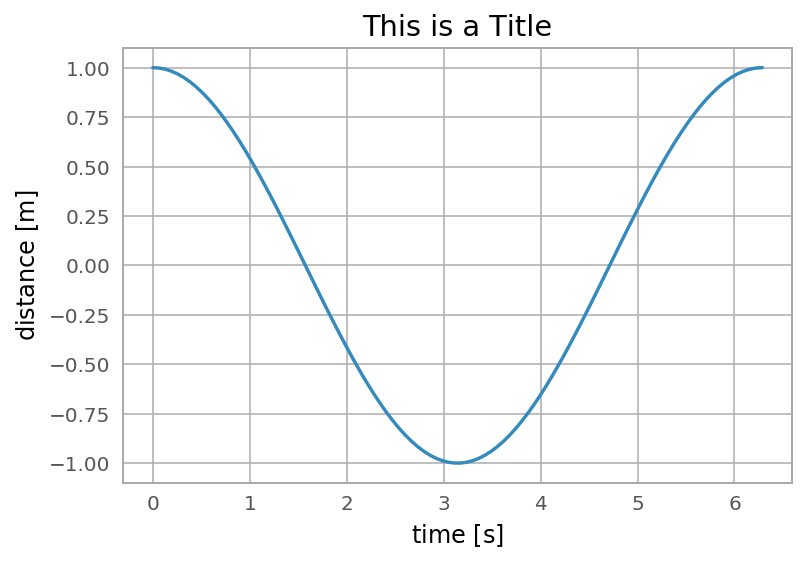

In [6]:
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel(f'time [{ax.get_xlabel()}]')
ax.set_ylabel(f'distance [{ax.get_ylabel()}]')
ax.set_title('This is a Title')

# Plotting Functions

In [7]:
def plot_distance(x, y):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_xlabel(f'time [{ax.get_xlabel()}]')
    ax.set_ylabel(f'distance [{ax.get_ylabel()}]')
    ax.set_title('This is a Title')
    return fig, ax

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a23d22630>)

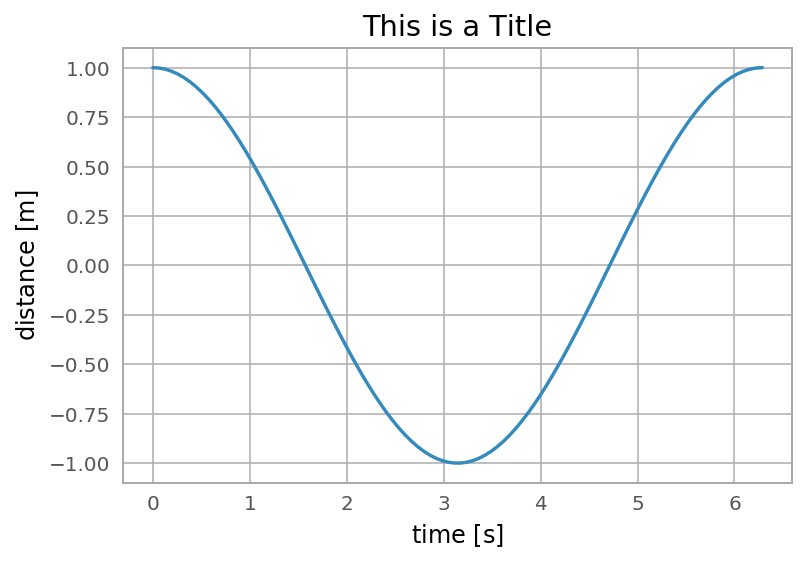

In [8]:
plot_distance(x, y)

but this will always make a new figure and axes and this is extremely inflexible

what if x, y don't have units attached?

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a23d22400>)

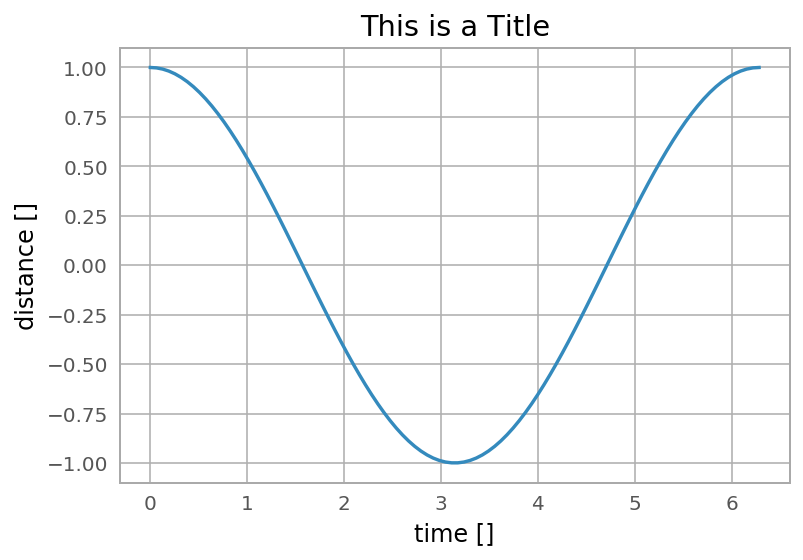

In [9]:
plot_distance(x.value, y.value)

This looks pretty silly.

In principle we could try to fix this with:

In [10]:
def plot_distance_custom(x, y, ax=None, has_units=True, title=''):
    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(x, y)
    
    if has_units:
        ax.set_xlabel(f'time [{ax.get_xlabel()}]')
        ax.set_ylabel(f'distance [{ax.get_ylabel()}]')
    else:
        ax.set_xlabel(f'time')
        ax.set_ylabel(f'distance')

    ax.set_title(title)
    return fig, ax

Great, now this is a responsive function

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2467e8d0>)

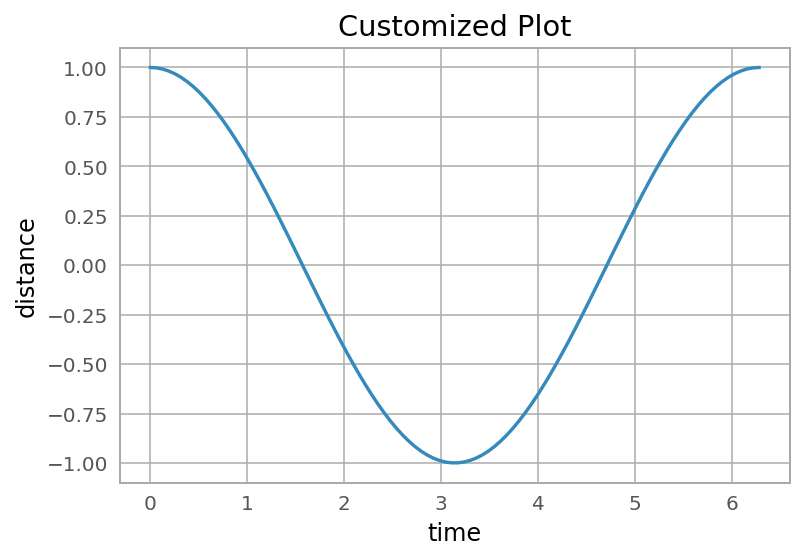

In [11]:
plot_distance_custom(x.value, y.value, ax=None, has_units=False, title='Customized Plot')

But what if we want to define a new function, `plot_distance_squared`? We have to go through this rigamarole all over again.

# Let There Be Decorators

In [12]:
_added_doc = """
Decorator
-------
ax: Axes (default None)
    will make new axes if None
has_units: bool
title: str
"""


class FigureDecorator(DecoratorClassBase):
    """this is a new decorator
    all we need to do is inherit from DecoratorClassBase,
    define a _doc_func and make our wrapper function
    """

    @staticmethod
    def _doc_func(docstring):
        return docstring + _added_doc
    
    def __call__(self, wrapped_function):
        """construct a function wrapper
        """
        @functools.wraps(wrapped_function)
        def wrapper(*func_args, ax=None, has_units=True, title=None, return_ax=False, savefig=None, **func_kwargs):

            if ax is None:  # setting new axes
                fig, ax = plt.subplots()
            else:
                plt.sca(ax)
            
            # calling function
            return_ = wrapped_function(*func_args, **func_kwargs)
            
            if has_units:
                ax.set_xlabel(f'{self.xlabel} [{ax.get_xlabel()}]')
                ax.set_ylabel(f'{self.ylabel} [{ax.get_ylabel()}]')
            else:
                ax.set_xlabel(f'{self.xlabel}')
                ax.set_ylabel(f'{self.ylabel}')
            
            if title is None and hasattr(self, 'title'):
                    ax.set_title(self.title)
            else:
                ax.set_title(title)
                
            if savefig is not None:
                if isinstance(savefig, str):
                    plt.savefig(savefig)
                else:
                    for sf in savefig:
                        plt.savefig(sf)

            if return_ax:
                return return_, ax
            return return_
        # /def

        return self.edit_docstring(wrapper)
    # /def



In [21]:
@FigureDecorator(xlabel='time', ylabel='distance', title='default title')
def plot_distance_dec(x, y):
    plt.plot(x, y)
    
    
@FigureDecorator(xlabel='time', ylabel='distance^2', title='another default title')
def plot_distance_squared_dec(x, y):
    plt.plot(x, y * y)
    plt.plot(x, y * y - 2 * y.unit**2)

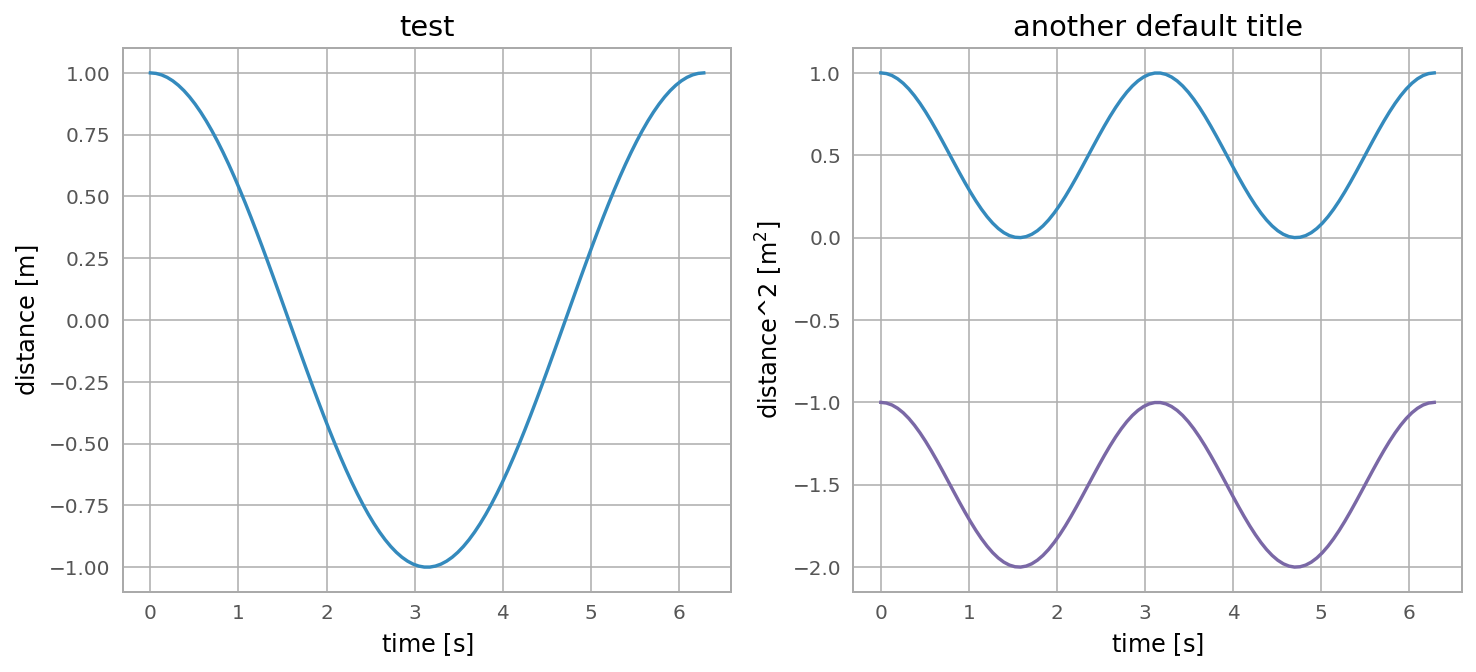

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plot_distance_dec(x, y, ax=axs[0], title='test')
plot_distance_squared_dec(x, y, ax=axs[1])

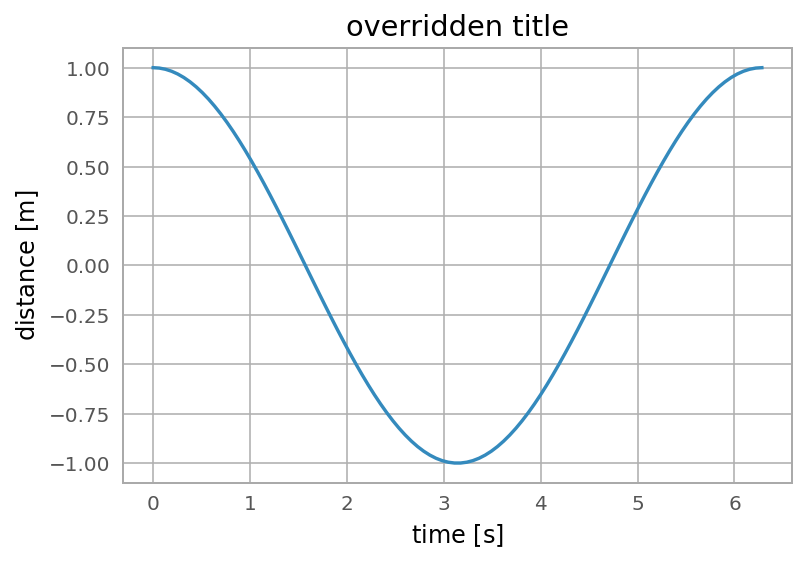

In [23]:
plot_distance_dec(x, y, title='overridden title')

we can do so much more.
I have been (slowly) developing a package called `starkplot` that implements this decorator-based 

In [24]:
plot_distance_dec(x, y, title='overridden title', savefig=('figures/loc1', 'figures/loc2'))
plt.close();

Showing the second save (`figures/loc2.png`)

![](figures/loc2.png)

<br><br>

- - - 
- - - 

<span style='font-size:40px;font-weight:650'>
    END
</span>